# Creating readers for Bruker MALDI data
This notebook will show you how to convert the rather cryptic mcf and mcf_idx files into more comprehensible and versatile hdf5 files. We will look at how to make use of the `ProjectMSI` class. 

## If you don't have R and rtms
If you don't have `R` and `rtms`, you should be able to continue with the section *Require methods* but I recommend you read the comments.

## Step by step
### Imports
First, we need to set up our environment by importing the objects we want to use

We recommend using the `get_project` function to get an instance. This function can also be used to get `ProjectXRF` instances (which we will explore in a different notebook, they are used to process micro-XRF data)

In [1]:
# make sure plots are being shown
%matplotlib inline  

# here we are accessing a method provided by the package
from maspim import get_project  
# this is a file inside the notebook folder to make working with the examples more comfortable
# in a real-world example you will need to provide the folder with your data but it is good practice to organize your folders in some
# python file
import user_params  

C:\Users\Yannick Zander\Downloads\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
# for this chapter we will use the test data with only 72 spectra
# this makes everything much quicker but some of the parameters have to be taken with a grain of salt 
# because some of the noise-cancelation properties that we see for hundreds of spectra do not occur on this scale
# (this affects mainly the window size for the baseline subtraction and the peak parameters)
path_folder = user_params.path_folder_test_data
# the get_project function can be used to get an XRF or MSI project by setting is_MSI accordingly
# notice that we only need to provide the folder with the measurement
project = get_project(is_MSI=True, path_folder=path_folder)

We can check that `project` is actually a `ProjectMSI` instance

In [3]:
type(project)

maspim.project.main.ProjectMSI

The `ProjectMSI` class is able to find the right files on its on and initializes the `ReadBrukerMCF` instance automatically.

In [4]:
project.set_hdf_file(delta_mz=5e-4)

creating BrukerMCF reader, this may take a while ...
Writing to hdf5: 100%|█████████████████████████████████████████████████████████████████| 72/72 [00:05<00:00, 13.44it/s]


### Require methods
It is even better to use `require` methods, which are available in this case and for many other steps as well which act in the following way:
* First, it tries to return a cached instance (for example if you called this function before in this sitting)
* Otherwise it checks if the requested object exists as a savestate on disk. If this is the case, it will be loaded and returned.
* If it does not exist yet, it will be initialized upon the method call with the default parameters (or those provided), create a savestate, and then return the instance.
Notice that the first two options ignore any provided keyword arguments. If you don't want to get the cached instance, you can call e.g. `project.forget('<object_name>')`. Alternatively, you can also use `overwrite=True` but this will overwrite the saved disk instance as well.

Overall, this method ensures that we obtain the requested object, whether it already exists or not.

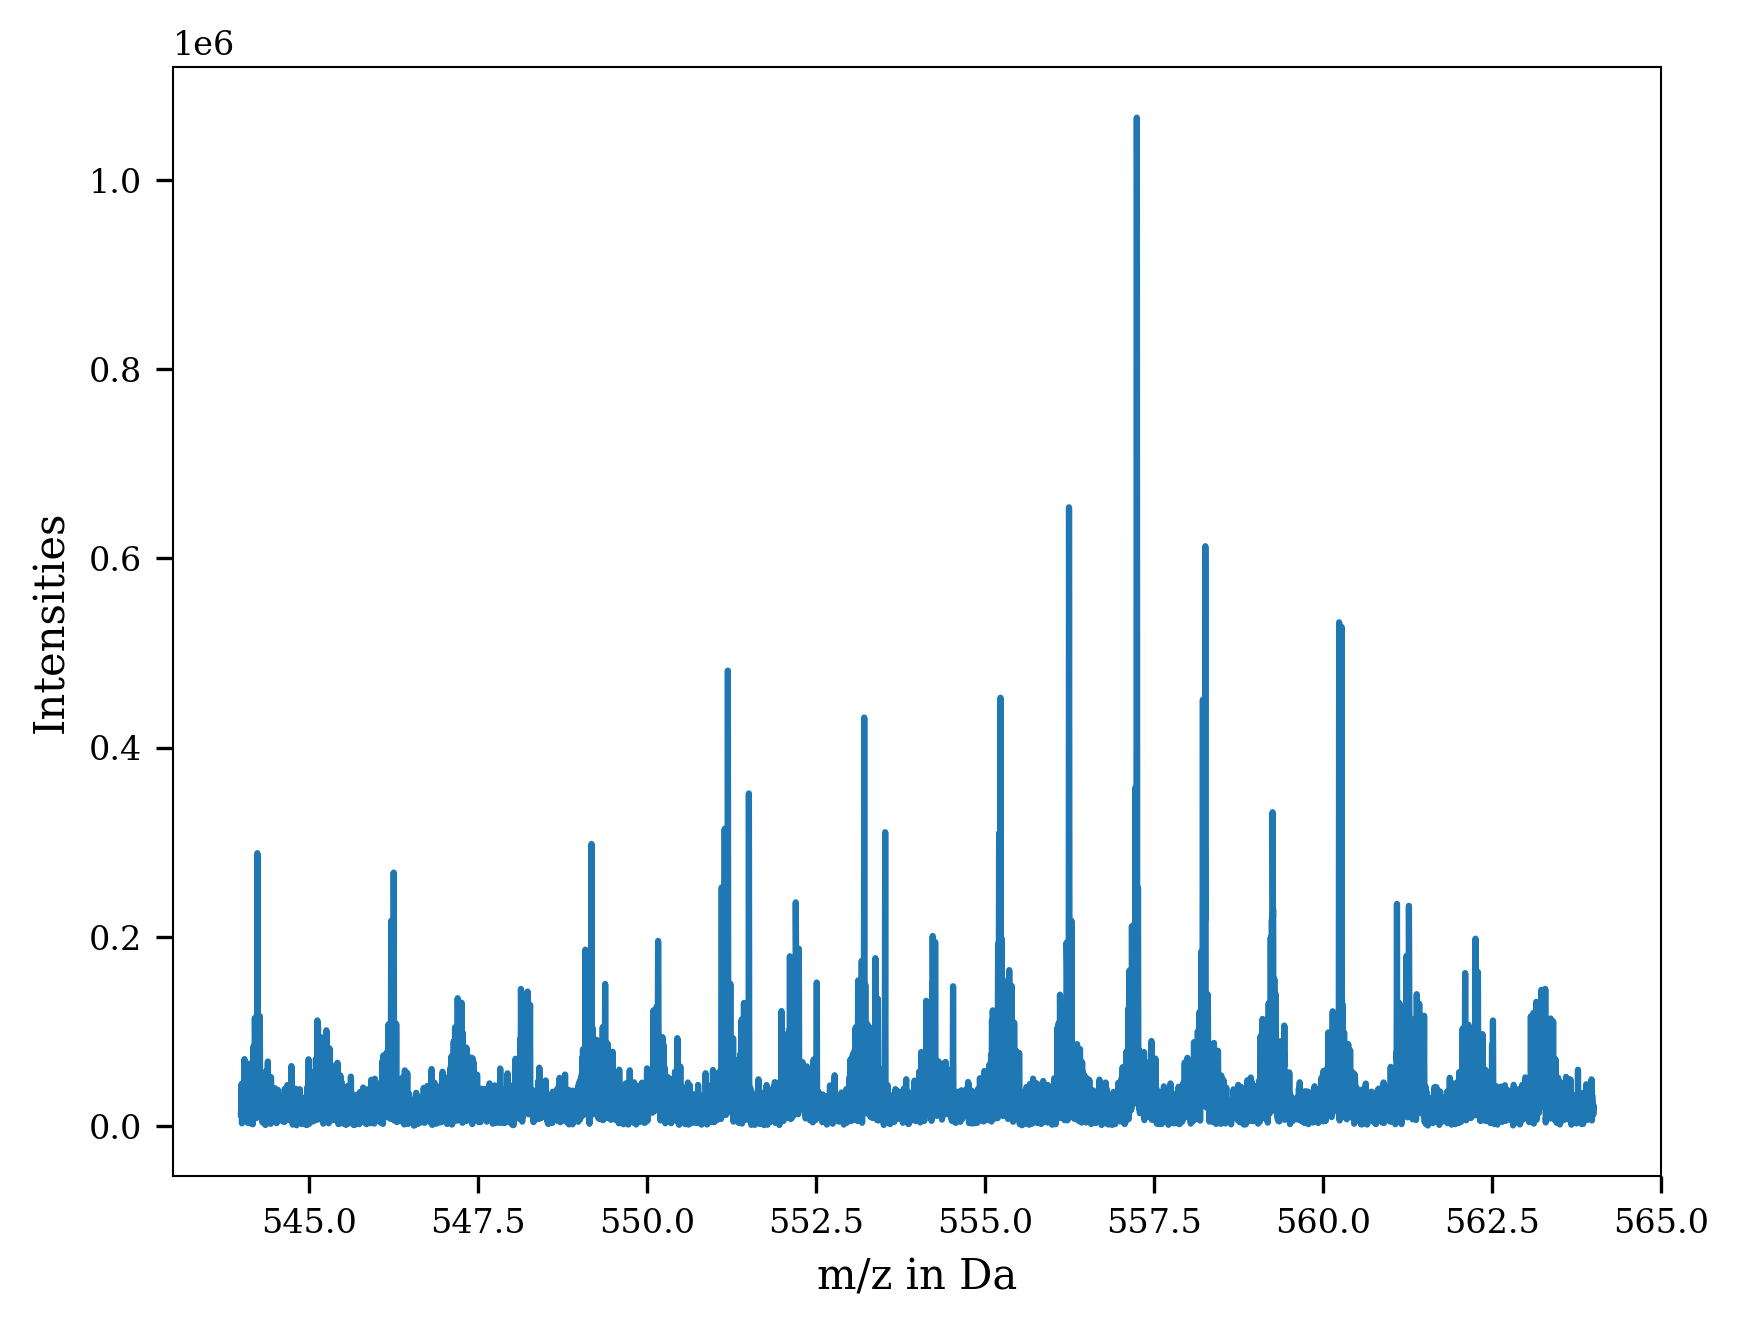

In [5]:
%matplotlib inline 

from maspim import get_project  
import user_params

path_folder = user_params.path_folder_test_data
project = get_project(is_MSI=True, path_folder=path_folder)

reader = project.require_hdf_reader()
reader.get_spectrum(5).plot('-')

Look at a few other spectra by changing the index in `get_spectrum`. Is spectrum 1 *noisy* or *clean*?

In [6]:
from tasks import chapter1_task1

chapter1_task1.ask()

If you want to avoid using hdf5 files, you can request an `ReadBrukerMCF` instance like this:

creating BrukerMCF reader, this may take a while ...


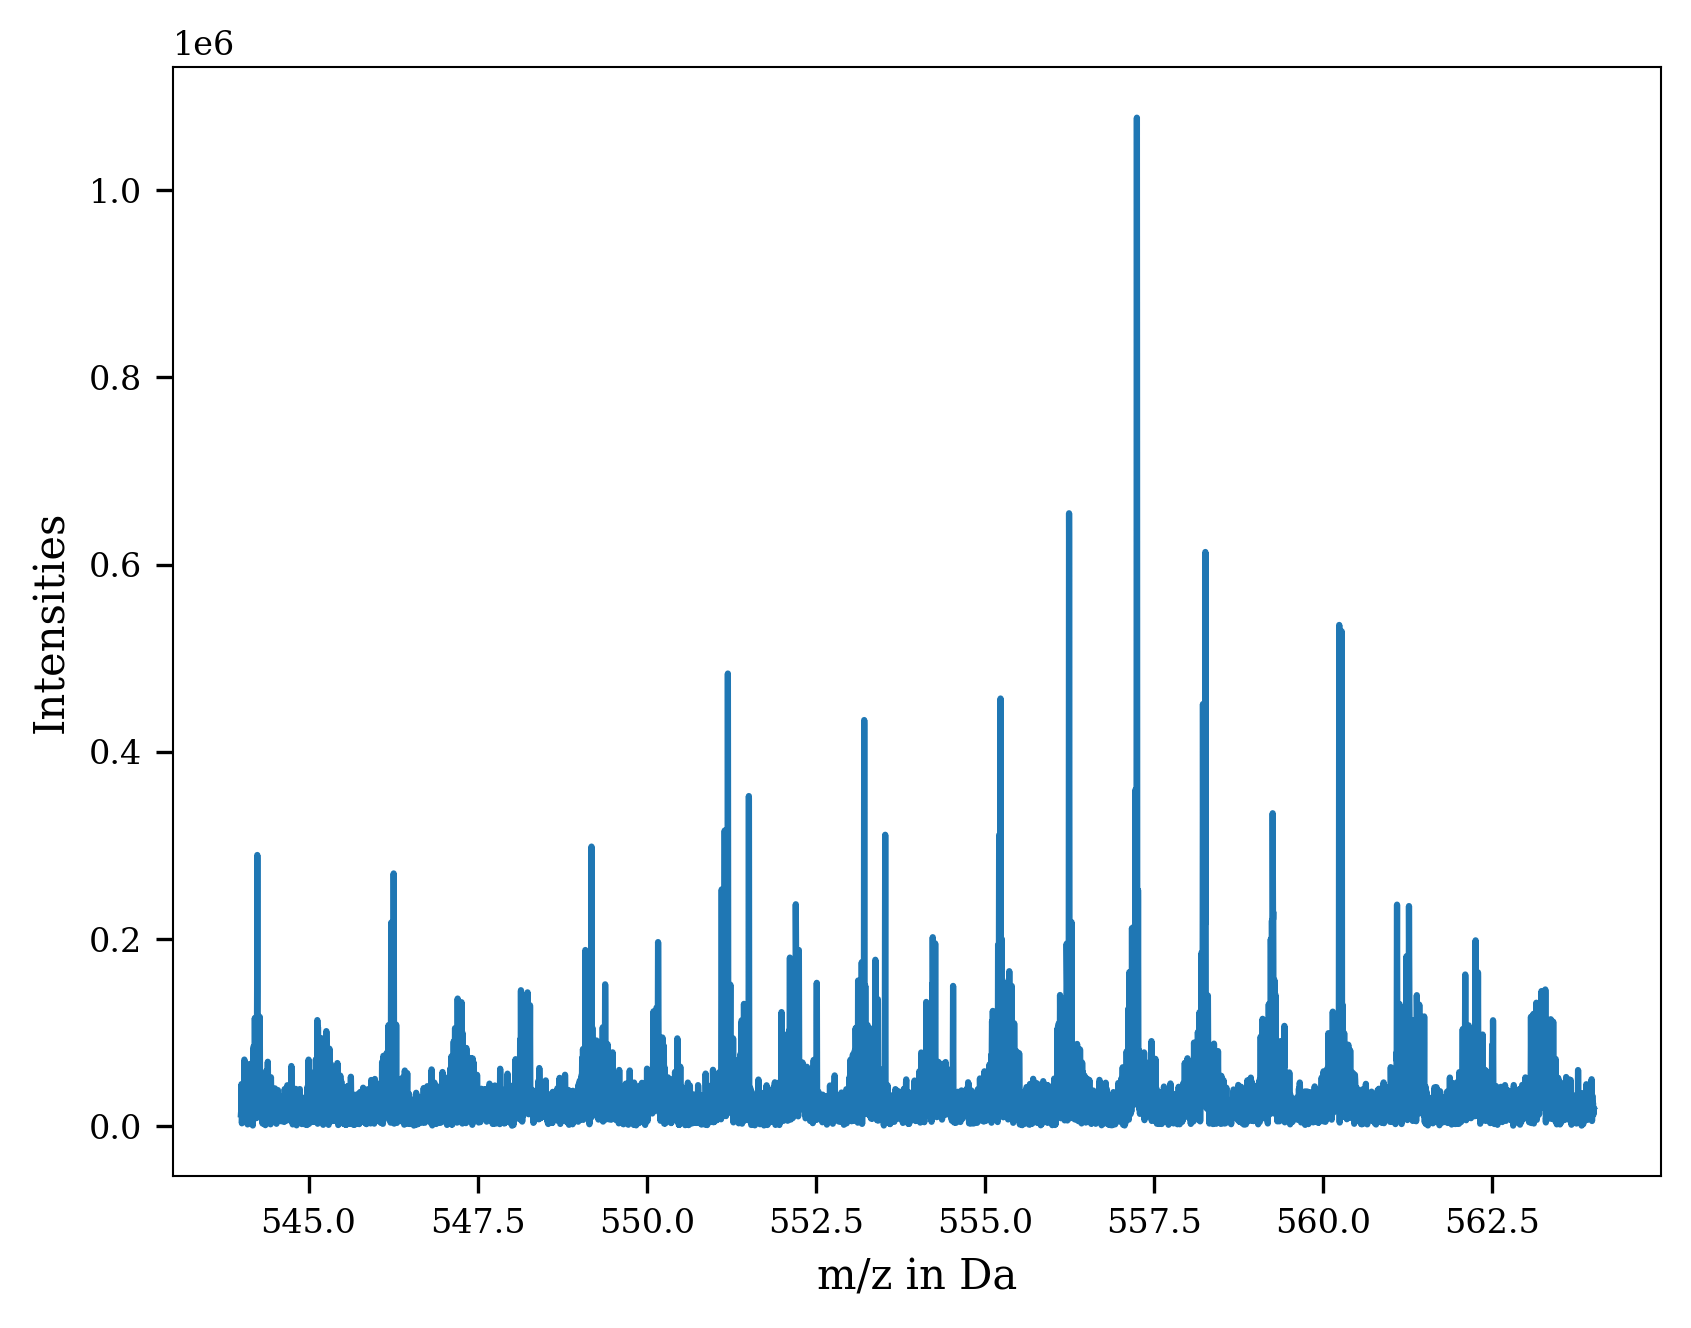

In [7]:
reader = project.get_mcf_reader()
reader.get_spectrum(5).plot('-')

## Choosing parameters
As mentioned above, the sampling interval has a big impact on the file size and also impacts downstream performance slightly. Therefore, it is worthwhile investigating if the sampling interval can be increased without much loss of information. Here we compare two sampling intervals and see some signal loss for the larger value. We encourage you to play around with the values to investigate at which point the deviations are noticeable. 

Let's first initialize the project (this time we only need a single spectrum and we want to take it from the `ReadBrukerMCF` instance (where it was not resampled)

In [8]:
from maspim import get_project

project = get_project(is_MSI=True, path_folder=path_folder)
mcf_reader = project.get_mcf_reader()
# try different resample values
delta_mzs = [1e-4, 1e-3]

creating BrukerMCF reader, this may take a while ...


Now resample the spectrum with different sample intervals

In [9]:
resampled = {'original': mcf_reader.get_spectrum(5)}
for dmz in delta_mzs:
    spectrum = mcf_reader.get_spectrum(5)
    spectrum.resample(delta_mz=dmz)
    resampled[dmz] = spectrum

and visualize the result

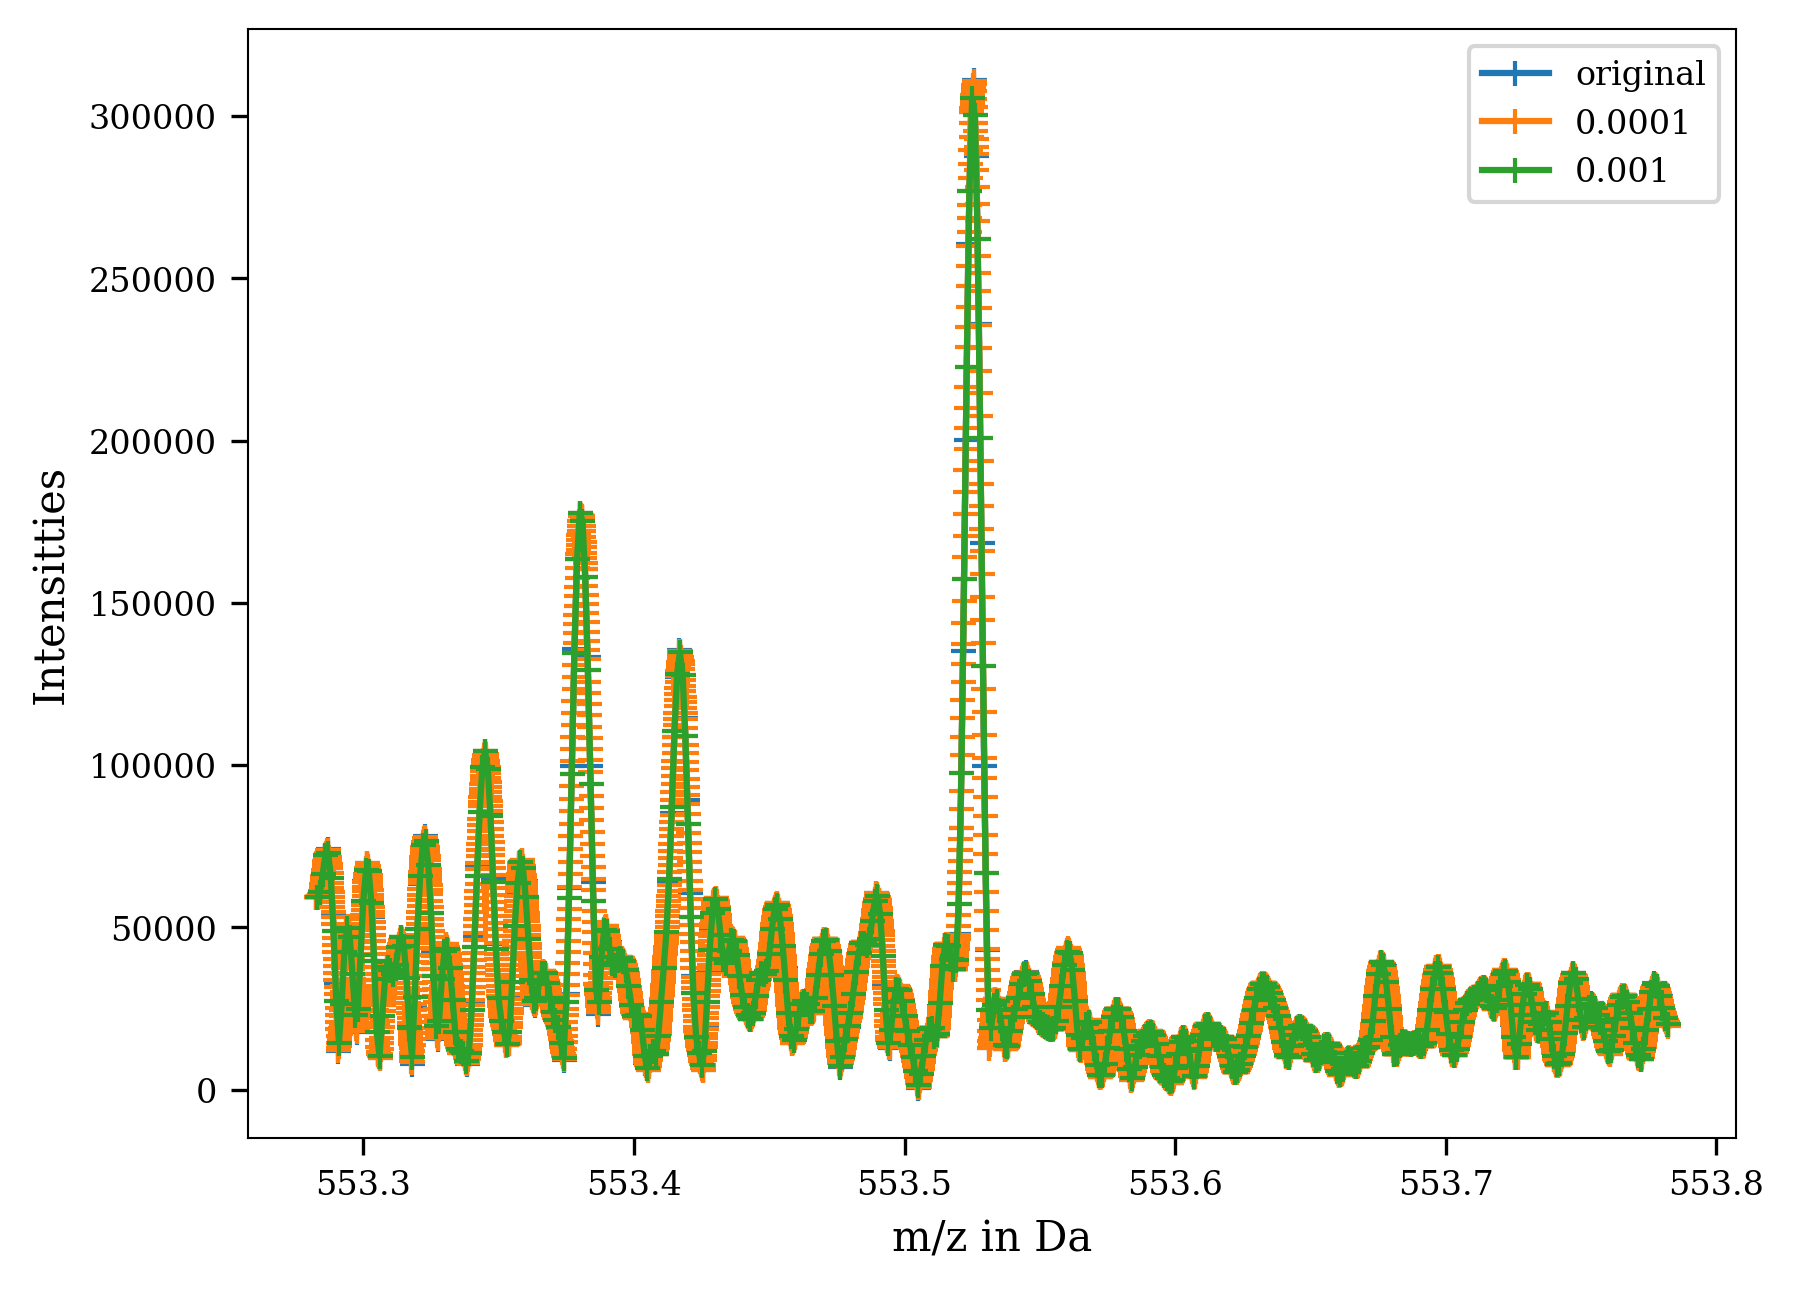

In [10]:
import matplotlib.pyplot as plt
import numpy as np

window_size = 500e-3  # Da

first_spec = list(resampled.values())[0]
# window around highest peak
# idx = np.argmax(first_spec.intensities)
idx = np.argmin(np.abs(first_spec.mzs - 553.5319))
peak = first_spec.mzs[idx]

for k, v in resampled.items():
    # only plot values around the peak
    mask = (v.mzs >= (peak - window_size / 2)) & (v.mzs <= (peak + window_size / 2))
    plt.plot(v.mzs[mask], v.intensities[mask], '+-', label=k)
plt.legend()
plt.xlabel('m/z in Da')
plt.ylabel('Intensitties')
plt.show()

We can see that a sampling interval of 1 mDa is not enough to maintain the peak shape. The effect on the general shape of peaks may be negligible, but at this point, you will also lose the precision of compounds in the feature table since the set of assignable masses is limited to those in the resampled spectra. Consequently, we'd recommend sticking to values between 0.1 and 1 mDa

### Quiz
Are the deviations still visible at a window size of 0.5 Da for $\Delta m/z = 50 mDa$ (no/yes)?

In [11]:
from tasks import chapter1_task2
chapter1_task2.ask()

Modify the values above (look at different spectra and peaks and `delta_mz` values). At which `delta_mz` value does the deviation from the original spectrum become too large (no input query for this as this is somewhat up to you)? 

### Quiz
What famous compound are you looking at if you uncomment the second idx line (C...)?

In [12]:
from tasks import chapter1_task3
chapter1_task3.ask()